

**Machine Learning I (Semester 1 2025)**
# Tutorial Session 9: Tree-Based Classifiers

*N. Hernitschek*



This Jupyter notebook is on Tree-Based Classifiers, a type of supervised classification methods.

It is based on code from the textbook

*An Introduction to Statistical Learning: with Applications in Python.*
James Witten, Hastie, Tibshirani; Springer.

which is vailable for free as PDF: https://www.statlearning.com/

, as well as

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray



***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Decision Trees](#first-bullet)
* [Random Forest Classifier](#second-bullet)
* [Random Forest Regressor](#third-bullet)


## 1. Decision Trees as Classifiers<a class="anchor" id="first-bullet"></a>

A decision tree provides a hierarchical application of decision boundaries.

The tree structure is as follows:

    top node contains the entire data set
    at each branch the data are subdivided into two child nodes
    split is based on a predefined decision boundary (usually axis aligned)
    splitting repeats, recursively, until we reach a predefined stopping criteria



The "leaf (terminal) nodes" record the fraction of points that have one classification or the other.

Application of the tree to classification is simple (a series of binary decisions). The fraction of points from the training set classified as one class or the other (in the leaf node) defines the class associated with that leaf node.

The binary splitting makes this extremely efficient. The trick is to ask the right questions. So, decision trees are simple to interpret (just a set of questions).

Scikit-learn implements the `DecisionTreeClassifier` as follows:


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)
dtree = DecisionTreeClassifier(max_depth=6)
dtree.fit(X,y)
y_pred = dtree.predict(X)
print(dtree.get_depth())
print(dtree.get_n_leaves())


5
11


We now want to use the `DecisionTreeClassifier` on a data set...

This data is from table 1 of Sesar et al 2010 ApJ 708:717

This returns the combined RR-Lyrae colors and SDSS standards colors. The RR-Lyrae sample is confirmed through time-domain observations; this result in a nice dataset for testing classification routines.

completeness [[0.00729927 0.3649635  0.29927007 0.62773723]
 [0.02189781 0.31386861 0.51824818 0.57664234]]
contamination [[0.66666667 0.375      0.31666667 0.31746032]
 [0.625      0.48809524 0.37719298 0.3875969 ]]


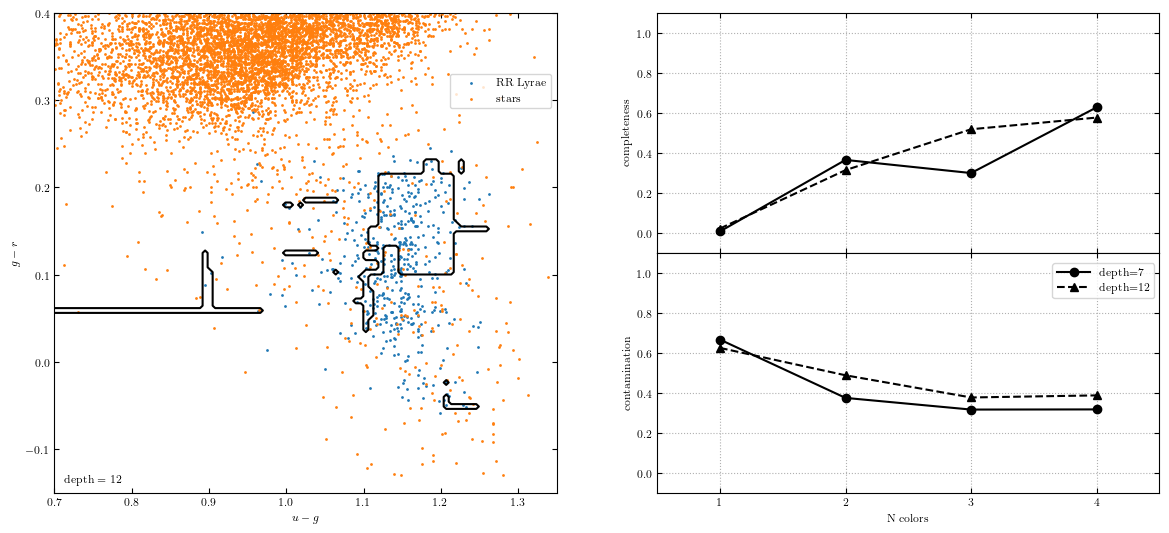

In [25]:

# Ivezic v2, Figure 9.13, edits by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit Decision tree
Ncolors = np.arange(1, X.shape[1] + 1)

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
depths = [7, 12]

for depth in depths:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth,
                                     criterion='entropy')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary

clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(13, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)

X_stars = X[np.where(y==0)]
X_rrlyrae = X[np.where(y==1)]

im = ax.scatter(X_rrlyrae[-N_plot:, 1], X_rrlyrae[-N_plot:, 0],
                s=4, lw=0, zorder=2,label="RR Lyrae")
im = ax.scatter(X_stars[-N_plot:, 1], X_stars[-N_plot:, 0],
                s=4, lw=0, zorder=2,label="stars")

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))


ax.text(0.02, 0.02, "depth = %i" % depths[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label="depth=%i" % depths[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()


## 2. Random Forest Classifier <a class="anchor" id="second-bullet"></a>


Random forest generate decision trees from bootstrap samples. A interesting aspect of random forests is that the features on which to generate the tree are selected at random from the full set of features in the data (the number of features selected per split level is typically the square root of the total number of attributes). The final classification from the random forest is based on the averaging of the classifications of each of the individual decision trees. So, you can literally give it the kitchen sink (including attributes that you might not otherwise think would be useful for classification).

Random forests help to overcome some of the limitations of decision trees.

As before, cross-validation can be used to determine the optimal depth. Generally the number of trees that are chosen is the number at which the cross-validation error plateaus.

Generally, Random rorest can be used for regression and classification settings.

We will first see an example for a Random Forest Classifier.





Here we are trying to distinguish quasars (in black) from stars (in grey).

RandomForestClassifier
DecisionTreeClassifier


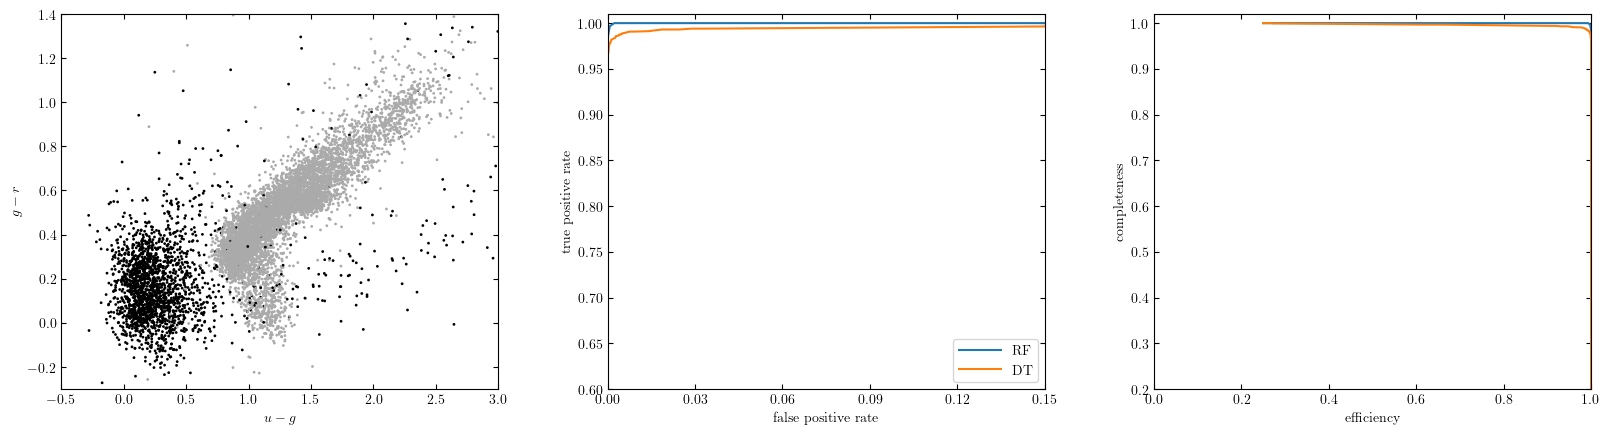

In [31]:

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from astroML.utils import split_samples

from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from astroML.classification import GMMBayes


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

#------------------------------------------------------------
# Fetch data and split into training and test samples
from astroML.datasets import fetch_dr7_quasar
from astroML.datasets import fetch_sdss_sspp

quasars = fetch_dr7_quasar()
stars = fetch_sdss_sspp()

# Truncate data for speed
quasars = quasars[::5]
stars = stars[::5]

# stack colors into matrix X
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['mag_u'] - quasars['mag_g']
X[:Nqso, 1] = quasars['mag_g'] - quasars['mag_r']
X[:Nqso, 2] = quasars['mag_r'] - quasars['mag_i']
X[:Nqso, 3] = quasars['mag_i'] - quasars['mag_z']

X[Nqso:, 0] = stars['upsf'] - stars['gpsf']
X[Nqso:, 1] = stars['gpsf'] - stars['rpsf']
X[Nqso:, 2] = stars['rpsf'] - stars['ipsf']
X[Nqso:, 3] = stars['ipsf'] - stars['zpsf']

y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)


#------------------------------------------------------------
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print(classifier.__name__)
        model = classifier(**kwargs)
        model.fit(X, y)
        y_prob = model.predict_proba(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((RandomForestClassifier, dict(n_estimators=5)    ),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')))

#------------------------------------------------------------
# Plot results
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(131)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              LogisticRegression='LR',
             RandomForestClassifier='RF')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(132)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    ax2.plot(fpr, tpr, label=labels[name])
    
    ######
    
# Third axis shows the completeness-efficiency curves

ax3 = fig.add_subplot(133)
for name, y_prob in zip(names, probs):
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax3.plot(1 - cont, comp, label=labels[name])
    
    
    
    #####


ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

ax3.set_xlabel('efficiency')
ax3.set_ylabel('completeness')
ax3.set_xlim(0, 1.0)
ax3.set_ylim(0.2, 1.02)


plt.show()



<font color='red'>How do you interprete the results?</font>

## 3. Random Forest Regressor <a class="anchor" id="third-bullet"></a>


Here we use a `RandomForestRegressor` to estimatiate galaxy redshifts from photometry, so-called "photo-$z$".



@pickle_results: using precomputed results from 'photoz_forest.pkl'


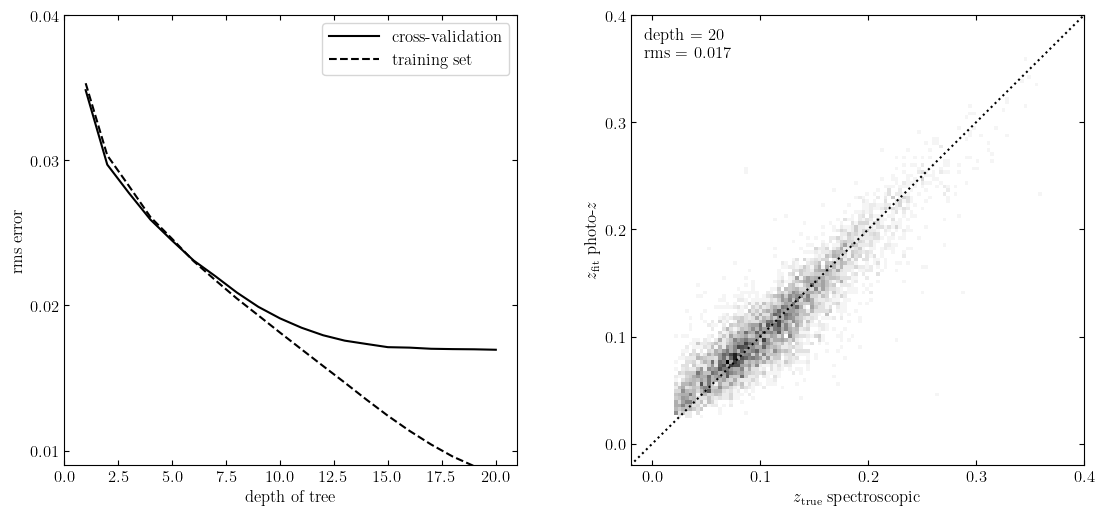

In [33]:
# Ivezic v2, Figure 9.15, edits by GTR
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 21)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)

edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$ spectroscopic')
ax.set_ylabel(r'$z_{\rm fit}$ photo-$z$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()



<font color='red'>How do you interprete the results?</font>

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how to use tree-based classifiers
* tree-based regressors
* seen how to use tree-based ensemble methods for classification (Random Forest)